In [32]:
import pandas as pd
import sys
sys.path.append('../utils')
import visualization as visualization
import generic as generic
import project_utils as project_utils
import numpy as np
import plotly.graph_objects as go


epidemy_years = ['2012_13', '2015_16', '2018_19', '2023_24']


### Load Data

In [33]:
dengue_data = pd.read_csv('../data/processed/dengue_data.csv')
daily_ovitraps = pd.read_csv('../data/processed/daily_ovitraps.csv',index_col=0, parse_dates=True)
ovitraps_data = pd.read_csv('../data/processed/ovitraps_data.csv')


### Process Data

In [34]:
# Dengue data
daily_dengue_data = project_utils.get_daily_dengue(dengue_data)
# ovitraps data
daily_ovitraps_sum = daily_ovitraps.sum(axis=1)
daily_ovitraps_mean = daily_ovitraps.mean(axis=1)


In [35]:
# Get the days for each epidemy year put them in flat list
day_anoepid = project_utils.get_epidemic_years_date_ranges_dengue(dengue_data)
epidemy_years_days = {year: days for year, days in day_anoepid.items() if year in epidemy_years}
epidemy_date_range = [
    pd.date_range(start=epidemy_years_days[year][0], end=epidemy_years_days[year][-1])
    for year in epidemy_years
]
epidemy_days_flat = [day for period in epidemy_date_range for day in period]


# Add anoepid to daily_dengue
daily_dengue_data_with_anoepid = daily_dengue_data.copy()
daily_dengue_data_with_anoepid = pd.DataFrame(daily_dengue_data_with_anoepid, index = daily_dengue_data_with_anoepid.index)
daily_dengue_data_with_anoepid.rename(columns={0: 'cases'}, inplace=True)

aux_list = [] 
for day in daily_dengue_data_with_anoepid.index:
    for key, value in day_anoepid.items():
        if day in value:
            aux_list.append((day,key))
    
aux_df = pd.DataFrame(aux_list, columns=['date', 'anoepid']).set_index('date')
daily_dengue_data_with_anoepid = daily_dengue_data_with_anoepid.merge(aux_df, how='outer', left_index=True, right_index=True)

# Define best group for correlation

## All years

In [66]:
max_corr = []
max_lag = []
for i in range(1,61):
    offset_days = abs((daily_ovitraps_mean.index[0] - daily_dengue_data.index[0]).days) % i
    
    groups_dengue = generic.group_series(
        series = daily_dengue_data,
        offset = offset_days,
        group_size = i,
        operation = "sum"
    )

    groups_ovitraps = generic.group_series(
        series = daily_ovitraps_mean,
        offset = 0,
        group_size = i,
        operation = "mean"
    )

    results = generic.max_correlation(groups_dengue, groups_ovitraps, max_lag = np.ceil(120/i).astype(int))
    
    max_lag.append(results[0])
    max_corr.append(results[1]) 

# Plot tuple of max_lag and max_corr
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,61)),
            y=max_corr,
            mode='markers+lines',
            name='Max Correlation',
            text=[f"corr={c:.2f}, lag={l}, group={g}" for c, l, g in zip(max_corr, max_lag, range(1, 61))],  
            textposition='top center' ,
            hoverinfo='text'
))
fig.update_layout(title='Max Correlation by Group Size - All Years',
                  xaxis_title='Group Size',
                  yaxis_title='Max Correlation')
fig.show()


## Epidemy Years

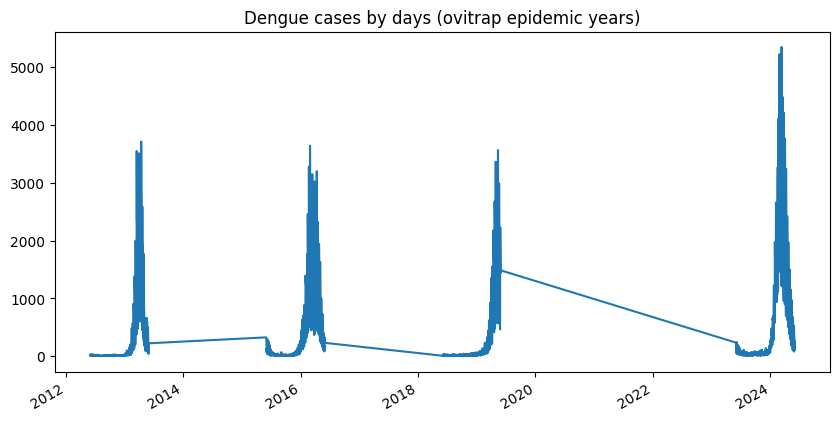

In [38]:
epidemic_mask_ovitraps = daily_dengue_data.index.map(lambda x: x in epidemy_days_flat)
daily_dengue_data_epidemic = daily_dengue_data[epidemic_mask_ovitraps]
daily_dengue_data_epidemic.plot(kind='line', figsize=(10, 5), title='Dengue cases by days (ovitrap epidemic years)')
daily_dengue_data_epidemic.index = daily_dengue_data_epidemic.index.map(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))


In [65]:
max_corr_epidemy = []
max_lag_epidemy = []
for i in range(1,61):
    offset_days = (daily_ovitraps_mean.index[0] - daily_dengue_data_epidemic.index[0]).days % i
    
    groups_dengue = generic.group_series(
        series = daily_dengue_data_epidemic,
        offset = offset_days,
        group_size = i,
        operation = "sum"
    )

    groups_ovitraps = generic.group_series(
        series = daily_ovitraps_mean,
        offset = 0,
        group_size = i,
        operation = "mean"
    )

    results = generic.max_correlation(groups_dengue, groups_ovitraps, max_lag = np.ceil(120/i).astype(int))

    max_lag_epidemy.append(results[0])
    max_corr_epidemy.append(results[1]) 

# Plot tuple of max_lag_epidemy and max_corr_epidemy
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,61)),
            y=max_corr_epidemy,
            mode='markers+lines',
            name='Max Correlation',
            text=[f"corr={c:.2f}, lag={l}, group={g}" for c, l, g in zip(max_corr_epidemy, max_lag_epidemy, range(1, 61))],  
            textposition='top center' ,
            hoverinfo='text'
))
fig.update_layout(title='Max Correlation by Group Size - Epidemy Years',
                  xaxis_title='Group Size',
                  yaxis_title='Max Correlation')
fig.show()


## Non-Epidemy Years

<Axes: title={'center': 'Dengue cases by days (non-epidemy years - dengue)'}>

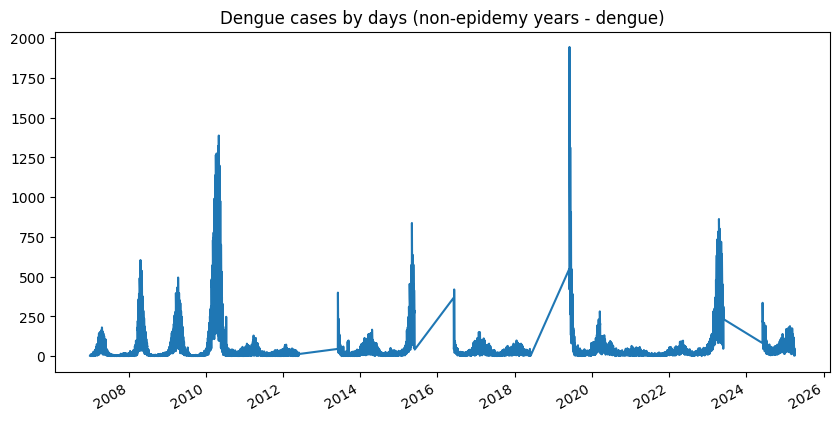

In [61]:
daily_dengue_data_non_epidemic = daily_dengue_data[~epidemic_mask_ovitraps]
daily_dengue_data_non_epidemic.index = daily_dengue_data_non_epidemic.index.map(lambda x: pd.to_datetime(x, format='%Y-%m-%d'))
daily_dengue_data_non_epidemic.plot(kind='line', figsize=(10, 5), title='Dengue cases by days (non-epidemy years - dengue)')


In [64]:
max_corr_non_epidemy = []
max_lag_non_epidemy = []
for i in range(1,61):
    offset_days = (daily_ovitraps_mean.index[0] - daily_dengue_data_non_epidemic.index[0]).days % i
    
    groups_dengue = generic.group_series(
        series = daily_dengue_data_non_epidemic,
        offset = offset_days,
        group_size = i,
        operation = "sum"
    )

    groups_ovitraps = generic.group_series(
        series = daily_ovitraps_mean,
        offset = 0,
        group_size = i,
        operation = "mean"
    )

    results = generic.max_correlation(groups_dengue, groups_ovitraps, max_lag = np.ceil(120/i).astype(int))

    max_lag_non_epidemy.append(results[0])
    max_corr_non_epidemy.append(results[1]) 

# Plot tuple of max_lag_non_epidemy and max_corr_non_epidemy
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,61)),
            y=max_corr_non_epidemy,
            mode='markers+lines',
            name='Max Correlation',
            text=[f"corr={c:.2f}, lag={l}, group={g}" for c, l, g in zip(max_corr_non_epidemy, max_lag_non_epidemy, range(1, 61))],  
            textposition='top center' ,
            hoverinfo='text',

))
fig.update_layout(title='Max Correlation by Group Size - Non Epidemy Years',
                  xaxis_title='Group Size',
                  yaxis_title='Max Correlation')
fig.show()


## Year-by-year

In [69]:
all_years = dengue_data.anoepid.unique()
all_years.sort()
max_correlation_dict = {}
for year in all_years:
    year_data = daily_dengue_data[daily_dengue_data_with_anoepid['anoepid'] == year]
    try:
        max_corr_year = []
        max_lag_year = []
        for i in range(1,31):
            offset_days = (daily_ovitraps_mean.index[0] - year_data.index[0]).days % i
            
            groups_dengue = generic.group_series(
                series = year_data,
                offset = offset_days,
                group_size = i,
                operation = "sum"
            )

            groups_ovitraps = generic.group_series(
                series = daily_ovitraps_mean,
                offset = 0,
                group_size = i,
                operation = "mean"
            )

            results = generic.max_correlation(groups_dengue, groups_ovitraps, max_lag = np.ceil(120/i).astype(int))

            max_lag_year.append(results[0])
            max_corr_year.append(results[1]) 

        # Plot tuple of max_lag_year and max_corr_year
        if year in epidemy_years:
            marker = '*'
        else:
            marker = '' 
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=list(range(1,31)),
                    y=max_corr_year,
                    mode='markers+lines',
                    name='Max Correlation',
                    text=[f"corr={c:.2f}, lag={l}, group={g}" for c, l, g in zip(max_corr_year, max_lag_year, range(1, 31))],  
                    textposition='top center' ,
                    hoverinfo='text',

        ))
        fig.update_layout(title=f'Max Correlation by Group Size - Year {year}{marker}', 
                        xaxis_title='Group Size',
                        yaxis_title='Max Correlation')
        fig.show()

    except ValueError as e:
        print(f"Skipping year {year} due to error: {e}")
        continue

Skipping year 2006_07 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2007_08 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2008_09 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2009_10 due to error: Both series must have at least one valid value to calculate correlation.
Skipping year 2010_11 due to error: Both series must have at least one valid value to calculate correlation.
